# **Reconstruction of 3D Genome Structure**

In [1]:
from typing import Any

import numpy.typing as npt

Not all biological processes can be explained by genomic variations alone.
Epigenetics is the study of changes in gene activity that do not involve alterations in the DNA sequence itself.

One aspect of epigenetics is the role of chromosome folding in the nucleus which has different biological impacts, most importantly on [transcriptional regulation](https://en.wikipedia.org/wiki/Transcriptional_regulation) (the disruption of which can lead to disease).
The human genome is very long when stretched end-to-end, yet it forms a dense packing in the nucleus, and hierarchical structures such as ([interphase](https://en.wikipedia.org/wiki/Interphase)) chromosome territories, A/B compartments, topologically associating domains (TADs), and chromatin loops can be observed.

> A/B compartment-associated regions are on the multi-Mb scale and correlate with either open and expression-active chromatin ("A" compartments) or closed and expression-inactive chromatin ("B" compartments).
> A compartments tend to be gene-rich, have high GC-content, contain histone markers for active transcription, and usually displace the interior of the nucleus.
> B compartments, on the other hand, tend to be gene-poor, compact, contain histone markers for gene silencing, and lie on the nuclear periphery.

> A TAD is a self-interacting genomic region, typically on the sub-Mb scale.
> DNA sequences within a TAD physically interact with each other more frequently than with sequences outside the TAD.

We can study chromosome structure through chromosome conformation capture techniques such as [Hi-C](https://en.wikipedia.org/wiki/Hi-C_(genomic_analysis_technique)).
The Hi-C protocol is depicted in the following figure.

<img src="images/hic_protocol.jpeg" width=800 />

First, the DNA is cross-linked to fix nearby regions.
Then the DNA is cut with a restriction enzyme and both ends are filled and labeled with biotin.
Note the use of a type III restriction enzyme that interacts with two separate DNA sequences in inversely repeated head-to-head orientations for efficient cleavage and later ligation.
Hi-C uses high-throughput sequencing to find the nucleotide sequence of fragments and uses paired-end sequencing, which retrieves a short sequence from each end of each ligated fragment.
As such, for a given ligated fragment, the two sequences obtained should represent two different restriction fragments that were ligated together in the proximity based ligation step.
The pair of sequences are individually aligned to the genome, thus determining the fragments involved in that ligation event.
Hence, all possible pairwise interactions between fragments are tested.
Hi-C is capable of capturing the interactions between loci across chromosomes, i.e., genome-wide.

The interactions (i.e., contacts) are then accumulated into a single matrix&nbsp;&mdash;&nbsp;the contact matrix $\mathbf{C}$.
Typically, these are intra-chromosomal contact matrices, representing interactions within a single chromosome.
Each row and column of the matrix represents a small region in a chromosome.
The size of these regions is referred to as "resolution" and is constant for the whole contact matrix.

<img src="images/contact_matrix.png" width=600 />

The number of contacts is inversely related to the (Euclidean) distance in three-dimensional space, since neighboring regions are more likely to interact.
Therefore, we can convert the contact matrix $\mathbf{C}$ into a a proxy of the Euclidean distance matrix (EDM) $\mathbf{D}$ using a conversion factor $\alpha$:

$$
D_{i,j} = \frac{1}{C^{\alpha}_{i,j}}.
$$

An important point is that Hi-C and similar protocols cannot reveal all possible interacting regions, i.e., there are many zero entries in the contact matrix.
We express this phenomenon with an observation operator $\mathcal{P}_{\mathbf{\Omega}}$:

$$
\begin{align}
\mathcal{P}_{\mathbf{\Omega}}(\mathbf{C})_{i,j} = 
\begin{cases}
    C_{i,j}, & (i,j) \in \mathbf{\Omega},\\
    0, & \text{otherwise}.
\end{cases}
\end{align}
$$

# Gram Matrix and Euclidean Distance Matrix

To estimate the three-dimensional structure of a chromosome given a set of observed interactions, we need to find the best point set representation&nbsp;&mdash;&nbsp;the positions of the DNA in space&nbsp;&mdash;&nbsp;given the set of observed interactions.
This problem is called [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) (MDS).

We define a set of $n$ points in $d$-dimensional space as a $d\times n$ coordinate matrix

$$
\mathbf{P} = 
\begin{bmatrix}
    \mathbf{p}_1 &
    \mathbf{p}_2 &
    \cdots &
    \mathbf{p}_i &
    \cdots &
    \mathbf{p}_n
\end{bmatrix}
$$

where $\mathbf{p}_i \in \mathbb{R}^{d}$ is the coordinate vector of $i$-th point in $d$-dimensional space.

The Gram matrix $\mathbf{G} \in \mathbb{R}^{n\times n}$ of a coordinate matrix $\mathbf{P}$ is defined as the inner product of all possible pairs of coordinate vectors:

$$
{G}_{i,j} \coloneqq \langle \mathbf{p}_i, \mathbf{p}_j \rangle = \mathbf{p}_i^T \mathbf{p}_j.
$$

Interestingly the EDM $\mathbf{D}$ can be computed from the Gram matrix $\mathbf{G}$ as

$$
\mathbf{D} = \text{diag}(\mathbf{G})\mathbf{1}^T + \mathbf{1}\text{diag}(\mathbf{G})^T - 2\mathbf{G},
$$

where $\mathbf{1}$ is the $n$-dimensional ones vector, and $\text{diag}(\mathbf{\cdot})$ is the operation that takes the diagonal of a matrix and creates a vector out of it.

Note that the EDM does not contain information about the absolute position and the orientation of the points in the coordinate matrix.
In other words, the EDM in invariant to rigid transformations (i.e., translation and rotation), including reflections, since these do not change the distances between points.

##### ❓ Gram matrix

Create a function named `coord2gram` that computes the Gram matrix from a coordinate matrix.

In [2]:
import numpy as np


def coord2gram(coord_mat: npt.NDArray[Any]) -> npt.NDArray[Any]:
    """Convert a matrix of coordinates to a Gram matrix."""
    return coord_mat.T @ coord_mat

In [3]:
p_1 = np.array([1, 0, 2])
p_2 = np.array([1, 1, 2])
coord_mat = np.stack((p_1, p_2)).T
gram_mat = coord2gram(coord_mat=coord_mat)

##### ❓ EDM

Create a function named `gram2edm` that computes the EDM from a Gram matrix.

In [4]:
def gram2edm(gram_mat: npt.NDArray[Any]) -> npt.NDArray[Any]:
    """Convert a Gram matrix to an Euclidean distance matrix."""
    diag_vec = np.diag(gram_mat).reshape((-1, 1))
    n, _ = gram_mat.shape
    ones_vec = np.ones(shape=(n, 1))
    ed_mat = diag_vec @ ones_vec.T + ones_vec * diag_vec.T - 2 * gram_mat
    return ed_mat

In [5]:
p_1 = np.array([1, 0, 2])
p_2 = np.array([1, 1, 2])
coord_mat = np.stack((p_1, p_2)).T
gram_mat = coord2gram(coord_mat=coord_mat)
ed_mat = gram2edm(gram_mat=gram_mat)
print(ed_mat)

[[0. 1.]
 [1. 0.]]


# Solving a Simulated Multi-Dimensional Scaling Problem

No we will try to solve an MDS problem using simulated data.
For this task, we will use a spiral-shaped string of beads (i.e., points) as a model of a chromosome.

##### ❓ A spiral-shaped string of beads as chromosome proxy

Use the provided spiral parameters.
Compute the `x`, `y`, and `z` components of all beads and create a coordinate matrix `coord_mat` from them.

> Hint: exploit the conversion from a cylindrical to a cartesian coordinate system.

In [6]:
SPIRAL_N_ROTATIONS = 4
SPIRAL_N_POINTS = 100
SPIRAL_HEIGHT = 1
SPIRAL_RADIUS = 0.5

spiral_end = SPIRAL_N_ROTATIONS * 2 * np.pi
bead_indexes = np.arange(SPIRAL_N_POINTS)

x = SPIRAL_RADIUS * np.cos((bead_indexes / SPIRAL_N_POINTS) * spiral_end)
y = SPIRAL_RADIUS * np.sin((bead_indexes / SPIRAL_N_POINTS) * spiral_end)
z = (bead_indexes / SPIRAL_N_POINTS) * SPIRAL_HEIGHT

coord_mat = np.stack([x, y, z])

In [7]:
import matplotlib.pyplot as plt


def scatter_3d(coord_mat: npt.NDArray[Any]) -> None:
    """Create a 3D scatter plot of the coordinates."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(*coord_mat)
    plt.show()

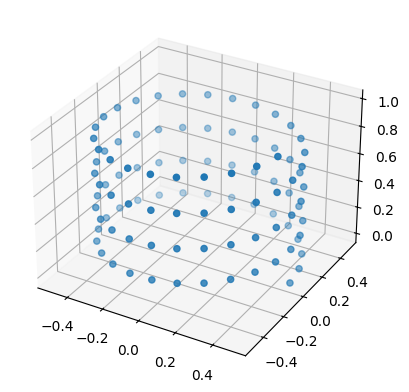

In [8]:
scatter_3d(coord_mat=coord_mat)

##### ❓ Simulation of a Hi-C protocol

Recall Hi-C and similar protocols cannot reveal all possible interacting regions, i.e., there are many zero entries in the contact matrix.
We express this phenomenon with an observation operator $\mathcal{P}_{\mathbf{\Omega}}$ (see above).

Simulate a Hi-C protocol by computing the EDM from the spiral coordinate matrix.
Then, sparsify the obtained EDM.
(This simulates that not all possible interacting regions are revealed.)
Retain 50% of the entries.
Recall that the EDM is symmetrical; hence, the sparsification must reflect this property.

In [9]:
ed_mat = gram2edm(gram_mat=coord2gram(coord_mat=coord_mat))

mask = np.random.randint(low=2, size=ed_mat.shape, dtype=bool)
mask = np.triu(mask)
mask = mask + mask.T

partial_ed_mat = ed_mat.copy()
partial_ed_mat[~mask] = 0

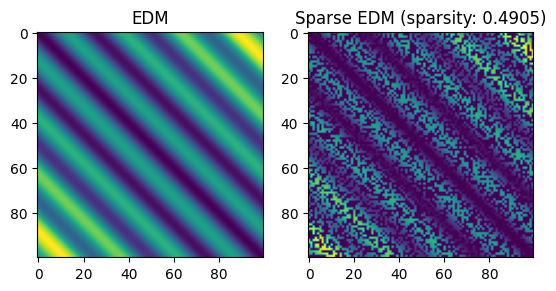

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title(label="EDM")
ax1.imshow(ed_mat)
ax1 = fig.add_subplot(1, 2, 2)
sparsity = mask.sum() / np.prod(mask.shape)
ax1.set_title(label=f"Sparse EDM (sparsity: {sparsity})")
ax1.imshow(partial_ed_mat)

##### ❓ Preparation for the estimation (using PyTorch) of the true 3D structure

The next step is to estimate the 3D structure of the spiral from the sparsified EDM using an optimization routine from PyTorch.

To estimate the 3D structure given a set of observed interactions, we need to find the best point set representation given the set of observed interactions.
Hence, as a first step, we need to initialize a point set.

Recall that we are working with tensors in PyTorch.

> In PyTorch, tensors are multi-dimensional arrays that are the fundamental data structures for representing and working with data.
> Tensors in PyTorch are similar to NumPy arrays, but they have the added benefit of being compatible with GPU acceleration, making them a key component for deep learning and neural network computations.

> One of the distinguishing features of PyTorch is its automatic differentiation capability, which is built on top of tensors.
> PyTorch keeps track of operations performed on tensors and allows you to compute gradients automatically for purposes like training neural networks using backpropagation.

Initialize a 3-by-`SPIRAL_N_POINTS` gradient-tracking PyTorch tensor filled with random numbers from a uniform distribution on the interval $[0,1)$.
Then, plot the generated point set using [`plotly.express.scatter_3d()`](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d).

In [11]:
import torch

# torch.manual_seed(seed=42)
predicted_coord_mat = torch.rand(size=(3, SPIRAL_N_POINTS), requires_grad=True)

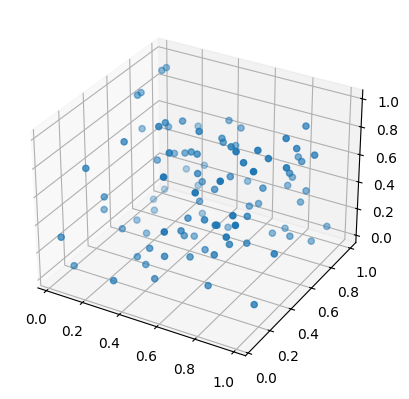

In [12]:
predicted_coord_mat_np = predicted_coord_mat.detach().numpy()
scatter_3d(coord_mat=predicted_coord_mat_np)

##### ❓ Optimization

First, as a preprocessing step, we convert the sparsified EDM into the coordinate format.

> The **COO**rdinate fornat is also known as the 'ijv' or 'triplet' format.
> It is used for the efficient representation of sparse matrices via three arrays: row indexes, column indexes, data (`data[i]` is the value at `row[i]`, `col[i]`).

We later need this representation to extract the relevant values to compute the loss during optimization.
Hence, we preemptively already convert the values to a PyTorch tensor.

In [13]:
from scipy.sparse import coo_matrix

partial_ed_mat_coo = coo_matrix(partial_ed_mat)

partial_ed_mat_row_ids = partial_ed_mat_coo.row
partial_ed_mat_col_ids = partial_ed_mat_coo.col
partial_ed_mat_values = torch.from_numpy(partial_ed_mat_coo.data).float()

We also need a PyTorch'd function to convert a coordinate matrix via the Gram matrix into an EDM:

In [14]:
def point2edm(coord_mat: torch.Tensor) -> torch.Tensor:
    """Convert a matrix of coordinates to an Euclidean distance matrix."""
    gram_mat = coord_mat.T @ coord_mat
    diag_vec = torch.diag(gram_mat).reshape(shape=(-1, 1))
    ones_vec = torch.ones((coord_mat.shape[1], 1))
    ed_mat = diag_vec @ ones_vec.T + ones_vec * diag_vec.T - 2 * gram_mat
    return ed_mat

Optimize the above-initialized coordinate matrix (`predicted_coord_mat`).

Try [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) and [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as optimizer and [`torch.nn.functional.mse_loss()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html) as loss function.

> Notice the difference in convergence speed between the different optimizers.

In each iteration of the optimization process, do the following:

1. Reset the gradients of all optimized tensors.
2. Compute the EDM from the current (to-be-optimized) coordinate matrix.
3. Compute the loss between the COO values of the sparse ground-truth EDM (`partial_ed_mat_values`) and the corresponding values from the current coordinate matrix.
4. Initiate the backprop and perform an optimization step.

In [15]:
from torch.nn.functional import mse_loss

optimizer = torch.optim.Adam(params=[predicted_coord_mat], lr=1e-1)

n_iterations = 100

for i in range(n_iterations):
    optimizer.zero_grad()
    predicted_ed_mat = point2edm(coord_mat=predicted_coord_mat)
    partial_predicted_ed_mat_values = predicted_ed_mat[
        partial_ed_mat_row_ids, partial_ed_mat_col_ids
    ]
    loss = mse_loss(input=partial_predicted_ed_mat_values, target=partial_ed_mat_values)
    loss.backward()
    optimizer.step()

    print(f"Iteration [{(i + 1):5}/{n_iterations:5}] | Loss={loss:8f}")

Iteration [    1/  100] | Loss=0.318408
Iteration [    2/  100] | Loss=0.267318
Iteration [    3/  100] | Loss=0.253803
Iteration [    4/  100] | Loss=0.235854
Iteration [    5/  100] | Loss=0.217614
Iteration [    6/  100] | Loss=0.196932
Iteration [    7/  100] | Loss=0.175059
Iteration [    8/  100] | Loss=0.156418
Iteration [    9/  100] | Loss=0.139200
Iteration [   10/  100] | Loss=0.120320
Iteration [   11/  100] | Loss=0.100475
Iteration [   12/  100] | Loss=0.082929
Iteration [   13/  100] | Loss=0.069575
Iteration [   14/  100] | Loss=0.060438
Iteration [   15/  100] | Loss=0.053773
Iteration [   16/  100] | Loss=0.048003
Iteration [   17/  100] | Loss=0.042556
Iteration [   18/  100] | Loss=0.037189
Iteration [   19/  100] | Loss=0.032705
Iteration [   20/  100] | Loss=0.029988
Iteration [   21/  100] | Loss=0.028254
Iteration [   22/  100] | Loss=0.025867
Iteration [   23/  100] | Loss=0.022686
Iteration [   24/  100] | Loss=0.019646
Iteration [   25/  100] | Loss=0.017502


Finally, plot the optimized point set using [`plotly.express.scatter_3d()`](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d).

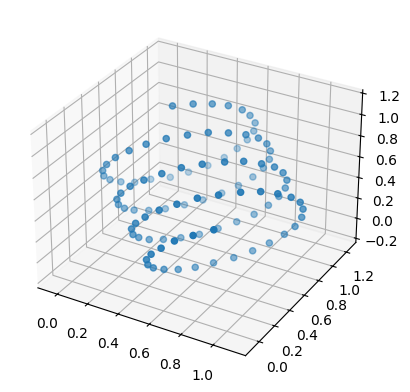

In [16]:
predicted_coord_mat_np = predicted_coord_mat.detach().numpy()
scatter_3d(coord_mat=predicted_coord_mat_np)